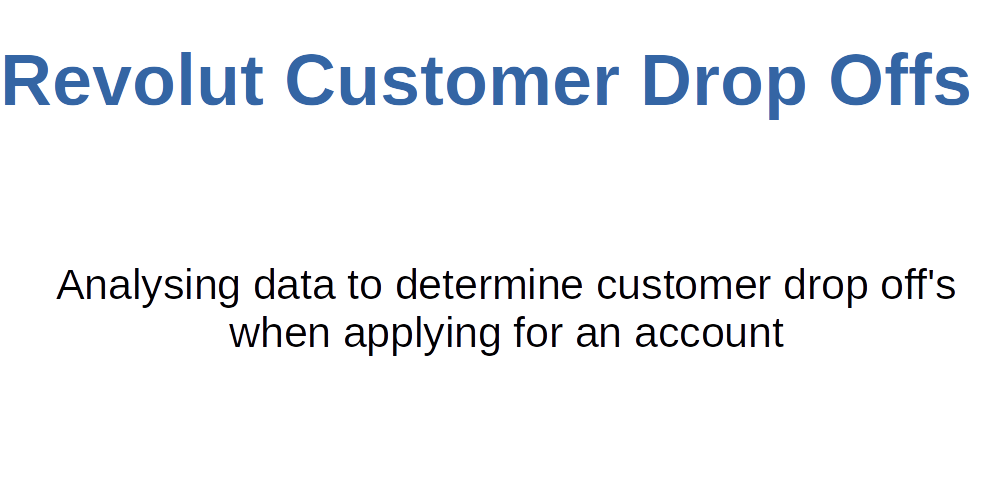

## Revolut · Analytical · Hometask

As a financial institution regulated by the FCA, Revolut has the obligation to verify the identity of
all customers who want to open a Revolut account. Each prospective customer has to go through
a Know Your Customer (KYC) process by submitting a government-issued photo ID and a facial
picture of themselves to our partner, Veritas. 

Veritas then would perform 2 checks:

* Document check: To verify that the photo ID is valid and authentic;
* Facial Similarity check: To verify that the face in the picture is the same with that on the submitted ID.

The customer will ‘pass’ the KYC process and get onboarded if the results of both Document and
Facial Similarity checks are ‘clear’. If the result of any check is not ‘clear’, the customer has to
submit all the photos again.

The “pass rate” is defined as the number of customers who pass both the KYC process divided
by the number of customers who attempt the process. Each customer has up to 2 attempts.
The pass rate has decreased substantially in the recent period.
Please write a report that outlines the root causes and suggest solutions.

Relevant files (please see the attached zip file)
* Reports of all Facial Similarity checks
* Reports of all Document checks
* veritas.html - API documentation of Veritas explaining some terms used in the reports.


(you need to download it to your computer and open it with a browser)


The candidate is free to use Excel or any scripting language to parse and analyse the data.
Please show all your work (including your code if applicable) and assumptions as well as provide
a pdf / keynote with your findings (outcomes).

# Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns  # visualization tool
import matplotlib.pyplot as plt # plotting
import json #for parse "properties" parameter
import warnings
warnings.filterwarnings('ignore')

### Functions to speed up data preprocessing

In [2]:
# Function for maping datasets. 
#We will change all 'consider' value to 1, and 'clear' = 0 for **map_encode_docs** list 
def result_encode(features, dataset):
    for feature in features:
        dataset[feature] = dataset[feature].map(result_map)

# function for clean and prepare dataframe        
def prepare_data(dataframe):
    dataframe.created_at = pd.to_datetime(dataframe.created_at,
                                          errors='coerce',
                                          format='%Y-%m-%d %H:%M:%S')
    dataframe.fillna(np.nan)
    
map_encode_all = ['result_doc', 
                  "visual_authenticity_result_doc", 
                  "image_integrity_result",                   
                  'police_record_result', 
                  'compromised_document_result',
                  "face_detection_result", 
                  "image_quality_result",
                  "supported_document_result",
                  'conclusive_document_quality_result',
                  'colour_picture_result', 
                  'data_validation_result',
                  'data_consistency_result', 
                  'data_comparison_result',
                  'face_comparison_result', 
                  'facial_image_integrity_result',
                  'visual_authenticity_result_face',
                  'result_face']

result_map = {"clear": 0, 'unidentified': 1, "consider" : 1}

## Reading **doc_reports.csv**
### Documentation regarding the doc_report (from Veritas)
> The document report is composed of data integrity, visual authenticity and police record checks. It checks the internal and external consistency of the most recent identity document provided by the applicant to identify potential discrepancies.

> In addition, any data extracted from the document through OCR is returned in the properties attribute.

> The document report combines software and an expert team to maximise fraud detection. The majority of documents will be processed instantly. However, when document analysis falls back to expert review, the report status will be delivered asynchronously via webhook notifications.

**Expert review is required when we encounter images that use sophisticated counterfeiting techniques, or the image is of poor quality (blurred, low resolution, obscured, cropped, or held at an unreadable angle).**

**BREAKDOWN**
* **visual_authenticity**	 - Asserts whether visual, non-textual, elements are correct given the type of document
* **image_integrity**	 - Asserts whether the document was of sufficient quality to verify
* **data_validation**	 - Asserts whether algorithmically-validatable elements are correct e.g. MRZ lines and document numbers
* **data_consistency** - Asserts whether data represented in multiple places on the document is consistent e.g. between MRZ lines and OCR extracted text on passports
* **data_comparison**	- Asserts whether data on the document is consistent with data provided by an applicant (either through Veritas’s applicant form or when creating an applicant through the API)
* **police_record** - Asserts whether the document has been identified as lost, stolen or otherwise compromised
* **compromised_document** - Asserts whether the image of the document has been found in our internal database of compromised documents

A result of clear in the conclusive_document_quality breakdown of image_integrity will assert if the document was of enough quality to be able to perform a fraud inspection. A result of consider will mean that even if sub breakdowns of visual_authenticity fail, we cannot positively say the document is fraudulent or not (in cases such as parts of the document are not visible).



## Reading **facial_similarity_reports.csv**
### Documentation regarding the face_similarity (from Veritas)
> The facial similarity check will compare the most recent live photo or live video provided by the applicant to the photo in the most recent identity document provided.

**BREAKDOWN**
* **face_comparison**	- Asserts whether the face in the document matches the face in the live photo or live video
* **image_integrity**	- Asserts whether the quality of the uploaded files and the content contained within them were sufficient to perform a face comparison
* **visual_authenticity**	- Asserts whether the live photo or live video is not a spoof (such as photos of printed photos or photos of digital screens)

**PROPERTIES**
The score property is a number between 0 and 1 that expresses how similar the two faces are, where 1 is a perfect match. If the report is completed manually or image integrity fails then the score property will not be present. The score only measures how similar the faces are, and does not make an assessment of the nature of the photo or video. If tampering (such as photos of printed photos or photos of digital screens) is detected the applicant will be rejected independently of the facial similarity score.

**STANDARD**
The standard variant uses live photos. The photo needs to be a live photo taken at the time of check submission, so that it can assess whether the holder of the identity document is the same person as the one on the document.

## Importing the Datasets

In [3]:
faces = pd.read_csv('facial_similarity_reports.csv', delimiter=',',index_col=0)
faces.dataframeName = 'facial_similarity_reports.csv'
prepare_data(faces)
faces.head()

,user_id,result,face_comparison_result,created_at,facial_image_integrity_result,visual_authenticity_result,properties,attempt_id
0,ab23fae164e34af0a1ad1423ce9fd9f0,clear,clear,2017-06-20 23:12:58+00:00,clear,consider,{},050a0596de424fab83c433eaa18b3f8d
1,15a84e8951254011b47412fa4e8f65b8,clear,clear,2017-06-20 23:16:04+00:00,clear,clear,{},f69c1e5f45a64e50a26740b9bfb978b7
2,ffb82fda52b041e4b9af9cb4ef298c85,clear,clear,2017-06-20 17:59:49+00:00,clear,clear,{},f9f84f3055714d8e8f7419dc984d1769
3,bd4a8b3e3601427e88aa1d9eab9f4290,clear,clear,2017-06-20 17:59:39+00:00,clear,clear,{},10a54a1ecf794404be959e030f11fef6
4,f52ad1c7e69543a9940c3e7f8ed28a39,clear,clear,2017-06-20 18:08:09+00:00,clear,clear,{},1f320d1d07de493292b7e0d5ebfb1cb9


In [4]:
document = pd.read_csv('doc_reports.csv', delimiter=',',index_col=0)
document.dataframeName = 'doc_reports.csv'
prepare_data(document)
document.head()

,user_id,result,visual_authenticity_result,image_integrity_result,face_detection_result,image_quality_result,created_at,supported_document_result,conclusive_document_quality_result,colour_picture_result,data_validation_result,data_consistency_result,data_comparison_result,attempt_id,police_record_result,compromised_document_result,properties,sub_result
0,ab23fae164e34af0a1ad1423ce9fd9f0,consider,consider,clear,clear,clear,2017-06-20 23:12:57+00:00,clear,NaN,NaN,clear,clear,NaN,050a0596de424fab83c433eaa18b3f8d,clear,NaN,"{'gender': 'Male', 'nationality': 'IRL', 'docu...",caution
1,15a84e8951254011b47412fa4e8f65b8,clear,clear,clear,clear,clear,2017-06-20 23:16:04+00:00,clear,NaN,NaN,clear,NaN,NaN,f69c1e5f45a64e50a26740b9bfb978b7,clear,NaN,"{'gender': 'Female', 'document_type': 'driving...",clear
2,ffb82fda52b041e4b9af9cb4ef298c85,clear,clear,clear,clear,clear,2017-06-20 17:59:49+00:00,clear,NaN,NaN,clear,clear,NaN,f9f84f3055714d8e8f7419dc984d1769,clear,NaN,"{'gender': 'Male', 'nationality': 'ITA', 'docu...",clear
3,bd4a8b3e3601427e88aa1d9eab9f4290,clear,clear,clear,clear,clear,2017-06-20 17:59:38+00:00,clear,NaN,NaN,clear,clear,NaN,10a54a1ecf794404be959e030f11fef6,clear,NaN,"{'gender': 'Male', 'issuing_date': '2007-08', ...",clear
4,f52ad1c7e69543a9940c3e7f8ed28a39,clear,clear,clear,clear,clear,2017-06-20 18:08:09+00:00,clear,NaN,NaN,clear,clear,NaN,1f320d1d07de493292b7e0d5ebfb1cb9,clear,NaN,"{'gender': 'Male', 'nationality': 'POL', 'docu...",clear


## Cleaning dataframes and dropping columns

Upon initial inspection it is obvious there is a lot of redundant data, namely, rows that have cleared checks and were approved. These are shown by the column `result` with an entry of `clear`. This information may still be important later so we will create two new datasets later.

There is also a lot of missing/unknown data which needs to cleaned up by changing the values to `0`.

Currently there is too much data in one DataFrame to make any real conclusions, but upon first inspection i can see that there is a correlation between the `sub_result` and `result` columns. Whenever a `sub_result` is not a value of `clear` then the main `result` is returned as `consider`.

In [5]:
df = pd.merge(document, faces, on='attempt_id', how='left', suffixes=('_doc', '_face'), validate='one_to_one')
df = df.drop([ 'user_id_face',  'created_at_face', 'sub_result', 'properties_face',], axis=1)

In [6]:
df.head()

,user_id_doc,result_doc,visual_authenticity_result_doc,image_integrity_result,face_detection_result,image_quality_result,created_at_doc,supported_document_result,conclusive_document_quality_result,colour_picture_result,...,data_consistency_result,data_comparison_result,attempt_id,police_record_result,compromised_document_result,properties_doc,result_face,face_comparison_result,facial_image_integrity_result,visual_authenticity_result_face
0,ab23fae164e34af0a1ad1423ce9fd9f0,consider,consider,clear,clear,clear,2017-06-20 23:12:57+00:00,clear,NaN,NaN,...,clear,NaN,050a0596de424fab83c433eaa18b3f8d,clear,NaN,"{'gender': 'Male', 'nationality': 'IRL', 'docu...",clear,clear,clear,consider
1,15a84e8951254011b47412fa4e8f65b8,clear,clear,clear,clear,clear,2017-06-20 23:16:04+00:00,clear,NaN,NaN,...,NaN,NaN,f69c1e5f45a64e50a26740b9bfb978b7,clear,NaN,"{'gender': 'Female', 'document_type': 'driving...",clear,clear,clear,clear
2,ffb82fda52b041e4b9af9cb4ef298c85,clear,clear,clear,clear,clear,2017-06-20 17:59:49+00:00,clear,NaN,NaN,...,clear,NaN,f9f84f3055714d8e8f7419dc984d1769,clear,NaN,"{'gender': 'Male', 'nationality': 'ITA', 'docu...",clear,clear,clear,clear
3,bd4a8b3e3601427e88aa1d9eab9f4290,clear,clear,clear,clear,clear,2017-06-20 17:59:38+00:00,clear,NaN,NaN,...,clear,NaN,10a54a1ecf794404be959e030f11fef6,clear,NaN,"{'gender': 'Male', 'issuing_date': '2007-08', ...",clear,clear,clear,clear
4,f52ad1c7e69543a9940c3e7f8ed28a39,clear,clear,clear,clear,clear,2017-06-20 18:08:09+00:00,clear,NaN,NaN,...,clear,NaN,1f320d1d07de493292b7e0d5ebfb1cb9,clear,NaN,"{'gender': 'Male', 'nationality': 'POL', 'docu...",clear,clear,clear,clear


## Encoding the columns using our function above
* 'consider' = 1 
* 'clear'    = 0 

In [7]:
result_encode(map_encode_all, df)

#fill all null/empty cells with 0
df.fillna(0, inplace=True)

In [8]:
df.head()

,user_id_doc,result_doc,visual_authenticity_result_doc,image_integrity_result,face_detection_result,image_quality_result,created_at_doc,supported_document_result,conclusive_document_quality_result,colour_picture_result,...,data_consistency_result,data_comparison_result,attempt_id,police_record_result,compromised_document_result,properties_doc,result_face,face_comparison_result,facial_image_integrity_result,visual_authenticity_result_face
0,ab23fae164e34af0a1ad1423ce9fd9f0,1,1.0,0.0,0.0,0.0,2017-06-20 23:12:57+00:00,0.0,0.0,0.0,...,0.0,0.0,050a0596de424fab83c433eaa18b3f8d,0.0,0.0,"{'gender': 'Male', 'nationality': 'IRL', 'docu...",0.0,0.0,0.0,1.0
1,15a84e8951254011b47412fa4e8f65b8,0,0.0,0.0,0.0,0.0,2017-06-20 23:16:04+00:00,0.0,0.0,0.0,...,0.0,0.0,f69c1e5f45a64e50a26740b9bfb978b7,0.0,0.0,"{'gender': 'Female', 'document_type': 'driving...",0.0,0.0,0.0,0.0
2,ffb82fda52b041e4b9af9cb4ef298c85,0,0.0,0.0,0.0,0.0,2017-06-20 17:59:49+00:00,0.0,0.0,0.0,...,0.0,0.0,f9f84f3055714d8e8f7419dc984d1769,0.0,0.0,"{'gender': 'Male', 'nationality': 'ITA', 'docu...",0.0,0.0,0.0,0.0
3,bd4a8b3e3601427e88aa1d9eab9f4290,0,0.0,0.0,0.0,0.0,2017-06-20 17:59:38+00:00,0.0,0.0,0.0,...,0.0,0.0,10a54a1ecf794404be959e030f11fef6,0.0,0.0,"{'gender': 'Male', 'issuing_date': '2007-08', ...",0.0,0.0,0.0,0.0
4,f52ad1c7e69543a9940c3e7f8ed28a39,0,0.0,0.0,0.0,0.0,2017-06-20 18:08:09+00:00,0.0,0.0,0.0,...,0.0,0.0,1f320d1d07de493292b7e0d5ebfb1cb9,0.0,0.0,"{'gender': 'Male', 'nationality': 'POL', 'docu...",0.0,0.0,0.0,0.0


## Initial theory

My initial thought was that there could be an issue with police checks, as some customers may have previous criminal history which would cause the application to be rejected, however when looking at these two columns I can see this is not the case as some entries with failed police checks were still approved. 

One thing I have noticed that is consistent with the application being rejected is `data_comparison_result`. When looking at the Veritas documentation the description of this column is: 

 “Asserts whether data on the document is consistent with data provided by an applicant (either through Veritas’s applicant form or when creating an applicant through the API)”

This says to me that one of the reasons why applications are being rejected is due the Documents that are being submitted do not match the information provided by the applicant.

Another factor that is consistent is when checking the for data validation, if the application fails on one or more of these checks, the `sub_result` is likely to return as a caution or suspected. 

Let's take a look at this further.

### Getting correlation dataframe for values

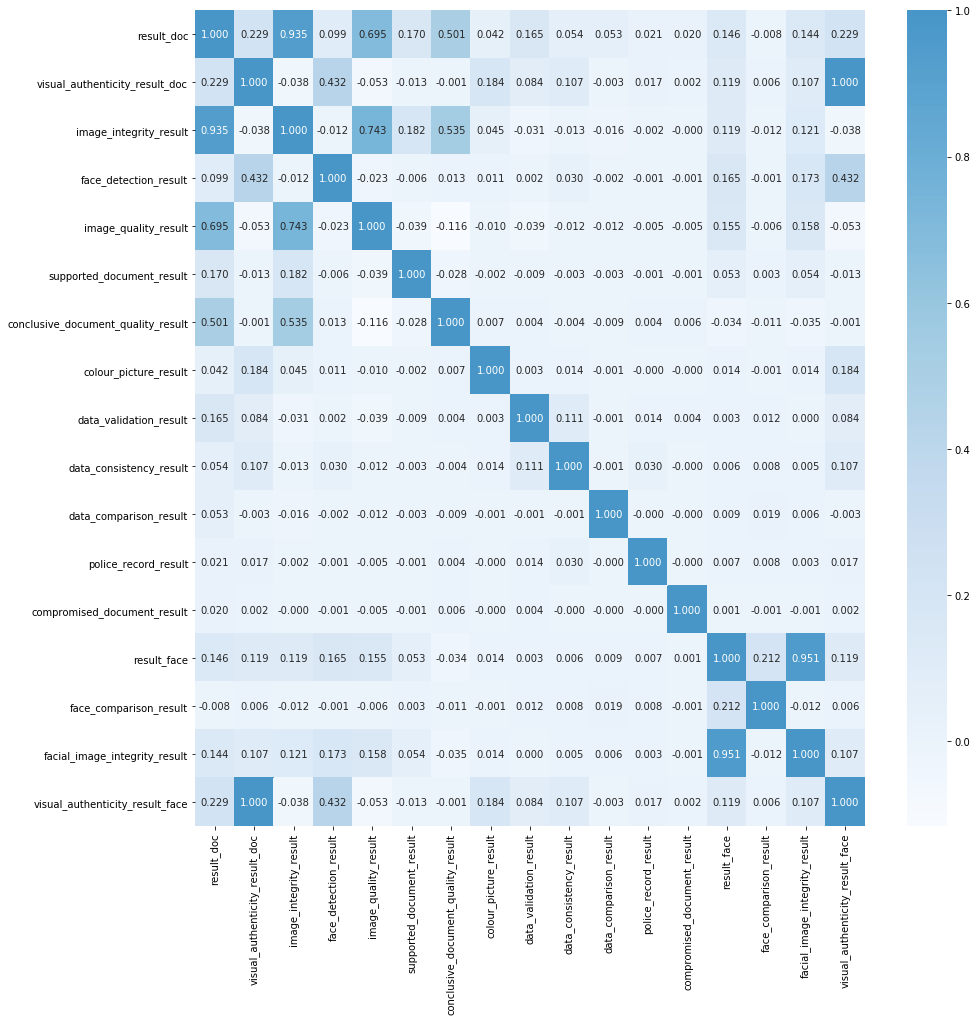

<Figure size 432x288 with 0 Axes>

In [9]:
df_corr = df.corr(method='pearson')

# correlation map plotting
f,ax = plt.subplots(figsize =(15,15))
sns.heatmap(df_corr, annot = True, fmt = '.3f', ax = ax, cmap='Blues', center=0.8)
plt.show()
plt.savefig('CorrelationChart', facecolor='white')

### `result_doc` has very high correaltion to `image_integrity_result` **0.953**: 
>  **image_integrity_result** - Asserts whether the document was of sufficient quality to verify.

### `result_face` has very high correlation to `facial_image_integrity_result`  **(0,951)** : 
>  **facial_image_integrity_result** - Asserts whether the quality of the uploaded files and the content contained within them were sufficient to perform a face comparison


It appears that these are the two key factors that influence whether an application fails or not. Which is not what I thought initialy. The actual quality of images and face recognition appears to be the main reason.

# Failure rate per stage of application

As you can see from the graphs below, there appears to be a rather sharp increase in failed applicaitions during the October period for Document Checks & image integrity.

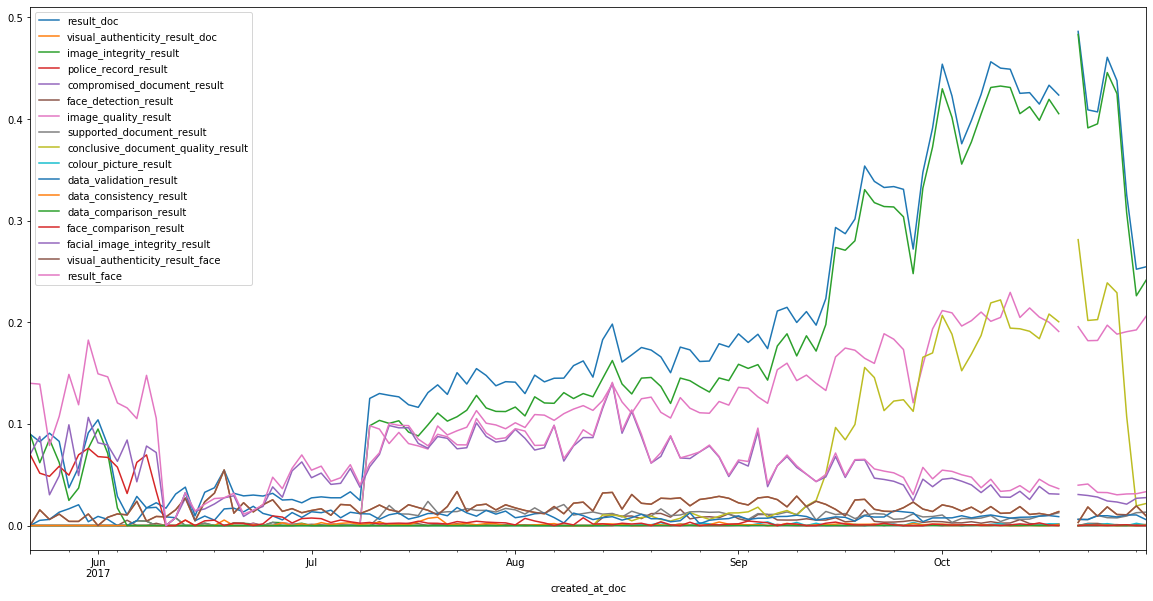

In [10]:
df.groupby(pd.Grouper(key='created_at_doc', freq='C'))[map_encode_all].mean().plot(figsize=(20,10))
plt.savefig('AllColumnsOverTime', facecolor='white')

In [11]:
suspected_params = ["image_integrity_result", 'facial_image_integrity_result', 'image_quality_result']

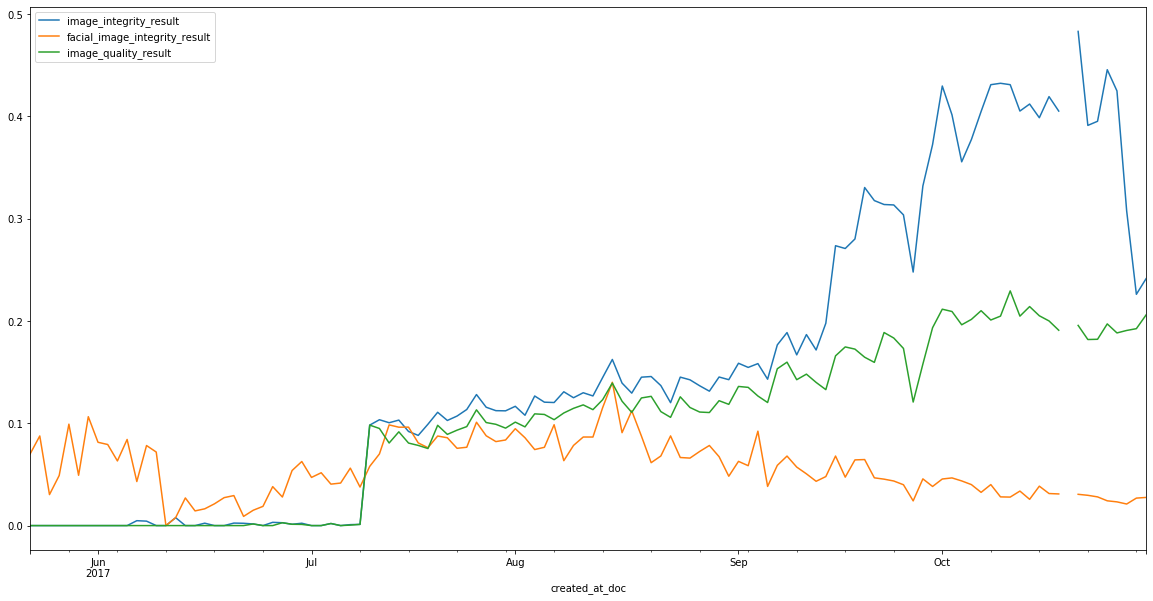

In [12]:
df.groupby(pd.Grouper(key='created_at_doc', freq='C'))[suspected_params].mean().plot(figsize=(20,10))
plt.savefig('SuspectedParamsOverTime', facecolor='white')

### Extracting Data from the `properties` column.

In [13]:
# Get clean data
df.properties_doc = df.properties_doc.apply(lambda row: row.replace('None', "\"NaN\""))
df['properties_doc'] = df.properties_doc.apply(lambda x: x.strip("\'<>()").replace('\'', '\"'))
# Load
df['properties_doc'] = df['properties_doc'].apply(json.loads, strict=False)
# Strip the data into correct columns
df = df.drop('properties_doc', 1).assign(**pd.DataFrame(df.properties_doc.values.tolist()))
# Get dates
df.date_of_expiry = pd.to_datetime(df.date_of_expiry, errors='coerce', format='%Y-%m-%d')
df.issuing_date = pd.to_datetime(df.issuing_date, errors='coerce', format='%Y-%m')
df = df.set_index(keys='created_at_doc')
df.head()

,user_id_doc,result_doc,visual_authenticity_result_doc,image_integrity_result,face_detection_result,image_quality_result,supported_document_result,conclusive_document_quality_result,colour_picture_result,data_validation_result,...,facial_image_integrity_result,visual_authenticity_result_face,gender,nationality,document_type,date_of_expiry,issuing_country,issuing_date,issuing_state,document_version
created_at_doc,,,,,,,,,,,,,,,,,,,,,
2017-06-20 23:12:57+00:00,ab23fae164e34af0a1ad1423ce9fd9f0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,Male,IRL,passport,2019-08-12,IRL,NaT,NaN,NaN
2017-06-20 23:16:04+00:00,15a84e8951254011b47412fa4e8f65b8,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,Female,NaN,driving_licence,2023-02-28,GBR,NaT,NaN,NaN
2017-06-20 17:59:49+00:00,ffb82fda52b041e4b9af9cb4ef298c85,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,Male,ITA,passport,2018-06-09,ITA,NaT,NaN,NaN
2017-06-20 17:59:38+00:00,bd4a8b3e3601427e88aa1d9eab9f4290,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,Male,NaN,national_identity_card,NaT,FRA,2007-08-01,NaN,NaN
2017-06-20 18:08:09+00:00,f52ad1c7e69543a9940c3e7f8ed28a39,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,Male,POL,national_identity_card,2019-05-29,POL,NaT,NaN,NaN


## 10 Most often **image_integrity_result** failure grouped by **issuing country**

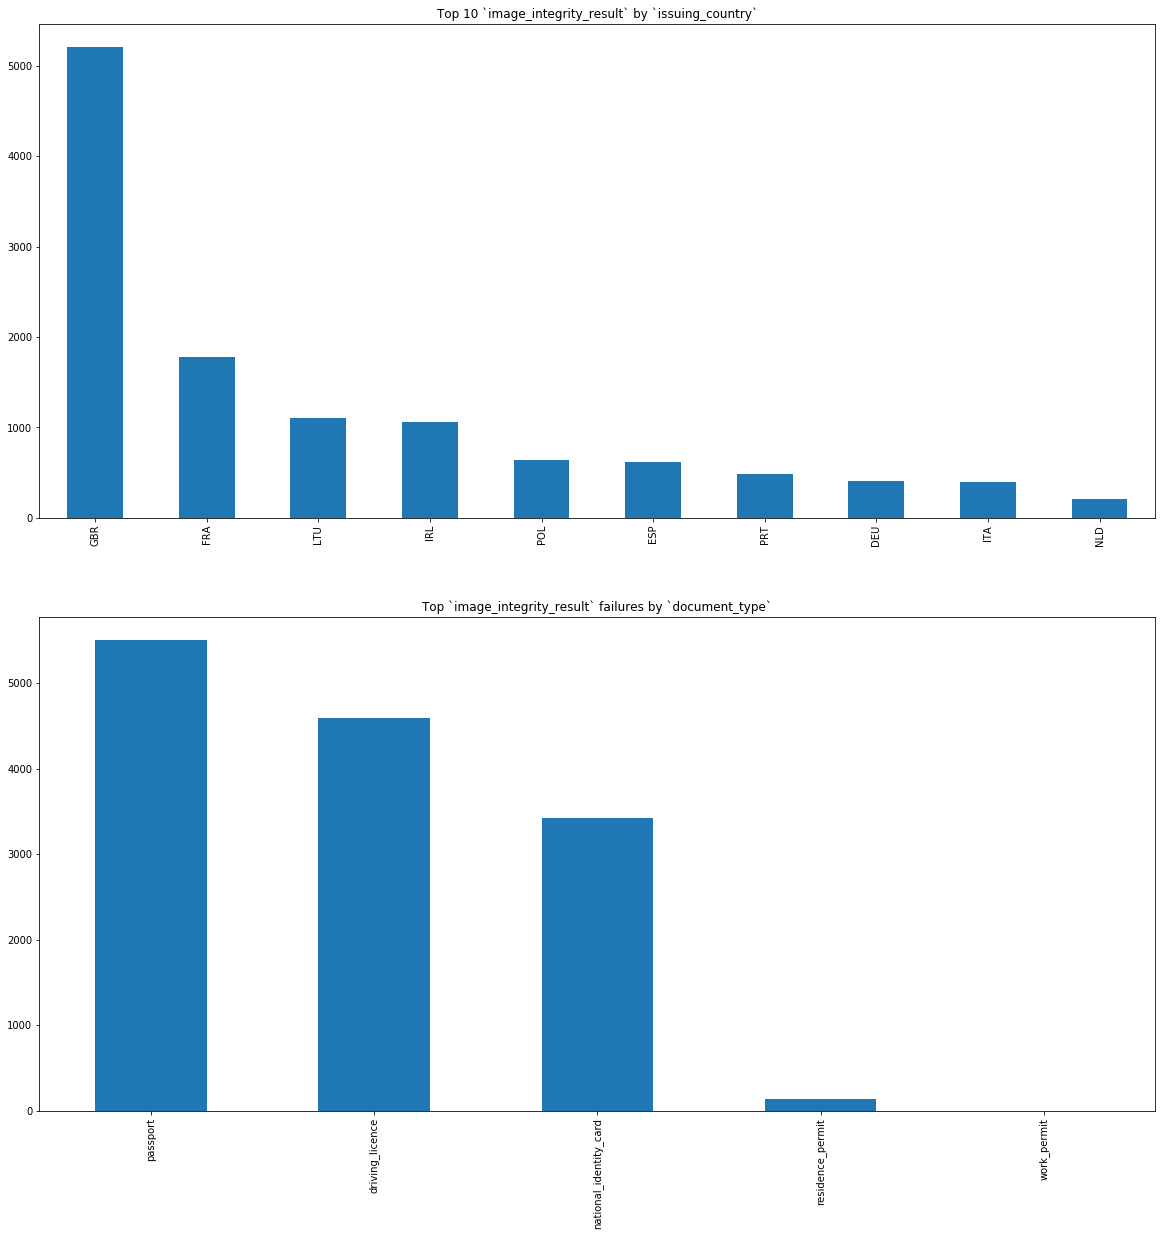

In [14]:
fig, axs = plt.subplots(2, figsize=(20, 20))
df[(df['result_doc'] == 1) & (df['image_integrity_result'] == 1)]['issuing_country'].value_counts()[:10].plot(ax=axs[0], kind='bar')
df[(df['result_doc'] == 1) & (df['image_integrity_result'] == 1)]['document_type'].value_counts()[:10].plot(ax=axs[1],kind='bar');


axs[0].set_title('Top 10 `image_integrity_result` by `issuing_country`')
axs[1].set_title('Top `image_integrity_result` failures by `document_type`')

plt.savefig('SuspectedParamsTop', facecolor='white');

## Top 10 Image Integrity failures by Country & Document Type
### Main period of issues (October)

In [15]:
problem_data = df['2017-10-10':'2017-10-25']

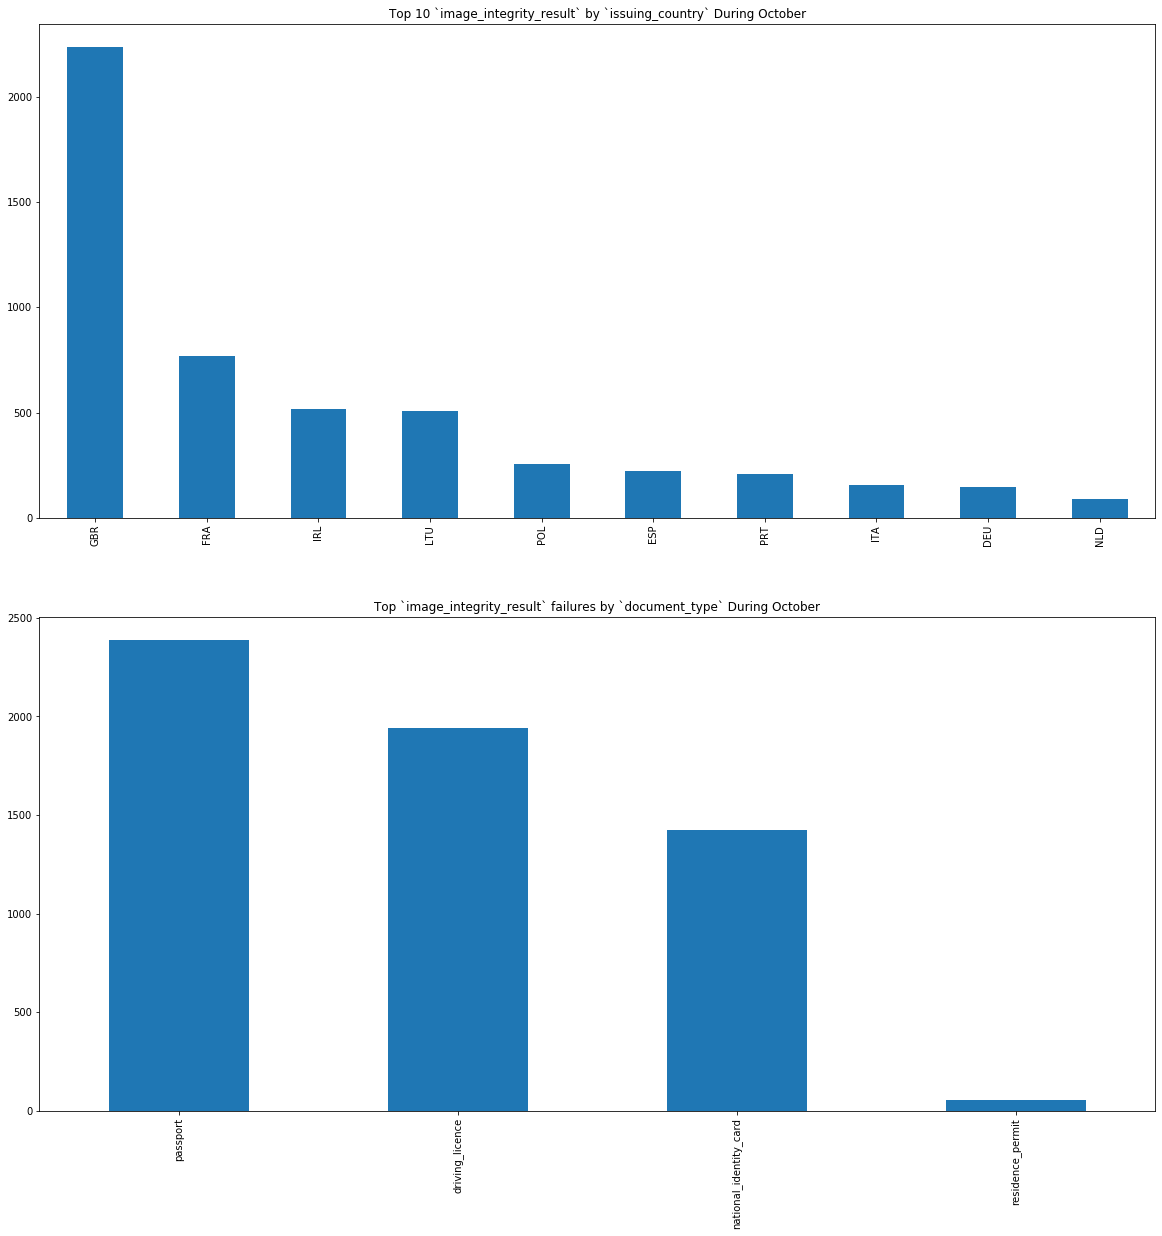

In [16]:
fig, axs = plt.subplots(2, figsize=(20, 20))
problem_data[problem_data['image_integrity_result'] == 1]['issuing_country'].value_counts()[:10].plot(ax=axs[0],kind='bar')
problem_data[problem_data['image_integrity_result'] == 1]['document_type'].value_counts()[:10].plot(ax=axs[1],kind='bar');
# plt.suptitle('Clear Vs Consider Over Time', fontsize=50)
axs[0].set_title('Top 10 `image_integrity_result` by `issuing_country` During October')
axs[1].set_title('Top `image_integrity_result` failures by `document_type` During October')

plt.savefig('SuspectedParamsTopOctober', facecolor='white');

In [17]:
df_consider = df[df['result_doc']==1]
df_consider[0:50]

,user_id_doc,result_doc,visual_authenticity_result_doc,image_integrity_result,face_detection_result,image_quality_result,supported_document_result,conclusive_document_quality_result,colour_picture_result,data_validation_result,...,facial_image_integrity_result,visual_authenticity_result_face,gender,nationality,document_type,date_of_expiry,issuing_country,issuing_date,issuing_state,document_version
created_at_doc,,,,,,,,,,,,,,,,,,,,,
2017-06-20 23:12:57+00:00,ab23fae164e34af0a1ad1423ce9fd9f0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,Male,IRL,passport,2019-08-12,IRL,NaT,NaN,NaN
2017-06-20 19:47:32+00:00,18b3422213bf4fd991c7e1736504def2,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,Male,TUN,passport,2020-09-08,TUN,NaT,NaN,NaN
2017-06-20 13:17:06+00:00,86b944b5d9524e20a39c3403700d26a2,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,Male,NaN,national_identity_card,NaT,FRA,2009-08-01,NaN,NaN
2017-06-20 13:46:39+00:00,df16b565b6b644a3aa4ea3bdd34f3663,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,Male,NaN,driving_licence,2024-10-10,GBR,NaT,NaN,NaN
2017-06-20 14:09:07+00:00,0dda8fb68b2a481ba370ba27d0678317,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,Male,GHA,passport,2019-12-03,GHA,NaT,NaN,NaN
2017-06-20 14:09:07+00:00,0dda8fb68b2a481ba370ba27d0678317,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,Male,GHA,passport,2019-12-03,GHA,NaT,NaN,NaN
2017-06-19 21:49:39+00:00,b3fdcc73fb8f49f880d96fd0701e63fb,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,NaN,NaN,driving_licence,2013-04-16,ITA,NaT,NaN,NaN
2017-06-19 19:04:41+00:00,adc9a80784fb4673ae69b67a35af776f,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,Male,NaN,driving_licence,2023-08-11,GBR,NaT,NaN,NaN
2017-06-19 12:42:16+00:00,87af2fb373a04e2c9b2b30a12a048e12,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,Male,NaN,national_identity_card,NaT,FRA,2011-06-01,NaN,NaN


# Findings & Possible Solutions

1. The total number of customers who cleared or failed the Document checks: 
    * clear        132402
    * consider     44002

**The percentage of people who cleared the checks is : 66.8%**

2. The total number of customers who cleared or failed the Face checks: 
    * clear        165486
    * consider     10917

**The percentage of people who cleared both checks is : 93.4%**

3. The total number of customers who cleared or failed the both checks: 
    * clear        126890
    * consider     5406

**The percentage of people who cleared both checks is : 95.8%**



As you can see from the above results there is only a 60% pass rate for the document checks, which is not great. When looking at the two graphs posted above you can see that the main cause for failed applications is due to image integrity.

When looking at the above table, it is clear that there is an issue with the document checks, whether it be incorrect information passed or, more likely that the images are poor quality, resulting in a failed check. There is a pattern that if the customer fails one of these checks then the result is likely to be `caution`.

The other similarity is that the `sub_result` responds with a `caution` value, again when checking the Documentation this does not strictly mean fraudulent activity is occurring but does indicate that details are mismatched between what the applicant has stated and what the documents provided show. Even though this is not strictly an indicator of fraud, in past experiences of handling fraudulent data, this is a big key indicator that this is most likely the case. 

Possible Solutions

I had to think about this a lot as there weren't many solutions for preventing people from attempting to create a fraudulent account, however, not all the drop off’s were related to fraud, some were just mismatched documents or errors from the user. 

These could be rectified by reviewing the the applications that failed as `caution`, these appear to be user error failures and not strictly fraud. By reviewing these applications manually you would be able to see whether the application was genuine or not. There is a feature that comes with Veritas to help with this.

**Expert review** 
As the API Documentation of Veritas tells us:¶

>"Expert review is required when we encounter images that use sophisticated counterfeiting techniques, or the image is of poor quality (blurred, low resolution, obscured, cropped, or held at an unreadable angle)."

